# Modeling the Appearance of West Nile Virus in Chicago

The city of Chicago is looking for ways to optimize its mosquito spraying procedures. Our task is to predict when and where mosquitos are most likely to carry the West Nile Virus.

#### Datasets
- train.csv: Data from every mosquito trap measurement during years 2007, 2009, 2011, 2013
- weather.csv: Daily weather patterns for the city of Chicago

#### Preprocessing
Preparing the data for analysis involved merging the two datasets. We employed a novel method to do this, calculating the distance between each trap and one of two weather stations identified in the weather dataset and then assigning a station number to each trap observation. This method also allowed us to better pinpoint the weather affecting each trap location.

We also conducted a principal component analysis to consolidate the many weather variables we were given, generating five principal components on which to build models.

#### Model Building
We employed two separate strategies in building models to predict the presence of West Nile Virus. The first strategy involved feature selection with SelectKBest and then performing a Random Forest Classifier. The second strategy involved conducting a cluster analysis to generate new features and then performing PCA on the weather data. These steps were followed by a logistic regression model. 

To facilitate running multiple models, we developed a function that could generate the classification metrics we needed to evaluate each model.

Additionally, when constructing our predictors, we placed a threshold of 0.2 on the predicted probability of a trap containing West Nile. Thus, rather than only predicting the presence of the virus in cases when there was < 0.5 predicted probability, we lowered the threshold to 0.2 to capture more potential hotspots. This strategy resulted in inflating our false-positive rate and decreasing our false-negative rate.

#### Model Evaluation
We evaluated three classification metrics in four models. Our most predictive model was a Random Forest Classifier using the 10 KBest features in the data. Below were the respective classification metrics for our best model:
- #### Recall score - .70
- #### Precision score - .18
- #### AUC score - .86

#### Conclusion
Our model correctly predicts the presence of West Nile virus 70% of the time. However, it has a high false-positive rate (29%). We expected a high false-positive rate due to our decision in the model-building stage to optimize for recall rather than precision. The upshot of all this is our predictions will result in spraying taking place unnecessarily in some areas, but most affected areas properly getting sprayed. The additional cost of spraying is a small price to pay for effective prevention of a deadly disease. 

In [11]:
# import all libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import binarize
from sklearn.grid_search import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define a random state and train test split % to use throughout
rs = 8
tts = .2

In [24]:
# define functions for classification model evaluation
def doClassifMetrics(y_test, y_pred):
    print 'Confusion Matrix \n', confusion_matrix(y_test, y_pred)
    print 'Classification Report \n', classification_report(y_test, y_pred)

def plotROC(y_test, y_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_log = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Auc Score: %f' % auc_log)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    
def modelEval(name, model, X, y, binarize_threshold):
#     X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=tts,
#         stratify = y, random_state = rs)
#     meancvscore = cross_val_score(model, X, y, n_jobs=-1, verbose=1).mean()
#     print 'Model %s cross_val_score: %.2f' % (name, meancvscore)
#     model.fit(X_train, y_train)
    y_pred = model.predict(X) # this uses default 50% probability threshold to predict 1
    y_proba = model.predict_proba(X)[:,1]
    y_pred_adj = binarize(y_proba, threshold = binarize_threshold, copy=True).transpose()
    print 'Model %s classification metrics with default pred threshold:' % name
    doClassifMetrics(y, y_pred)
    print 'Model %s using prediction threshold %f:' % (name, binarize_threshold)
    doClassifMetrics(y, y_pred_adj)
    print 'Model %s ROC curve and AUC' % name
    plotROC(y, y_proba)
    

In [29]:
# temporary

def modelEval2(name, model, X, y, binarize_threshold):
#     X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=tts,
#         stratify = y, random_state = rs)
#     meancvscore = cross_val_score(model, X, y, n_jobs=-1, verbose=1).mean()
#     print 'Model %s cross_val_score: %.2f' % (name, meancvscore)
#     model.fit(X_train, y_train)
    y_pred = model.predict(X) # this uses default 50% probability threshold to predict 1
    y_proba = model.predict_proba(X)[:,1]
    y_pred_adj = binarize(y_proba, threshold = binarize_threshold, copy=True).transpose()
#     print 'Model %s classification metrics with default pred threshold:' % name
#     doClassifMetrics(y, y_pred)
#     print 'Model %s using prediction threshold %f:' % (name, binarize_threshold)
#     doClassifMetrics(y, y_pred_adj)
#     print 'Model %s ROC curve and AUC' % name
#     plotROC(y, y_proba)
    return y_pred_adj

In [30]:
# read in cleaned and merged data
df = pd.read_csv('Assets/merged.csv')

## Visualizations

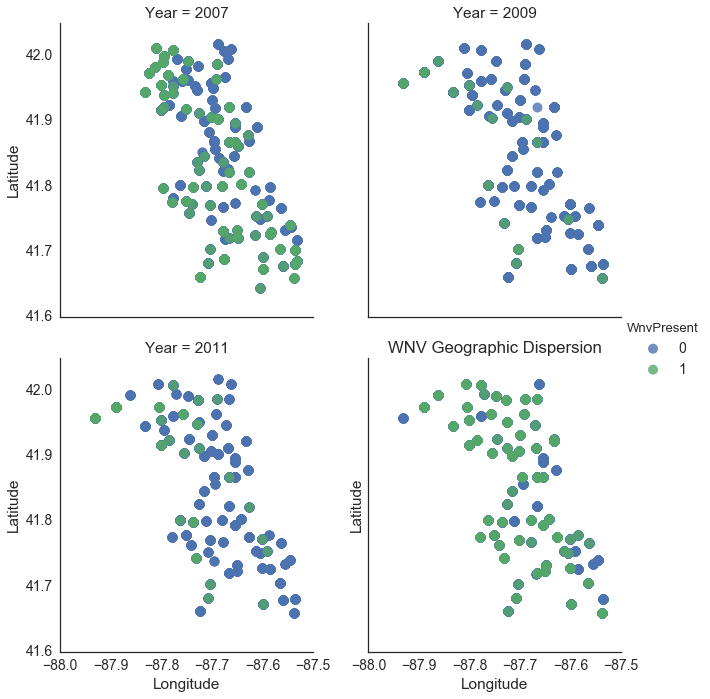

In [15]:
sns.set_context("notebook", font_scale=1.4)
sns.set_style("white")
sns.lmplot('Longitude', 'Latitude',
           data=df, 
           fit_reg=False, aspect = .9, col_wrap=2,
           hue="WnvPresent", col='Year', legend_out=True, scatter_kws={"marker": "D", "s": 100})
plt.title('WNV Geographic Dispersion')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

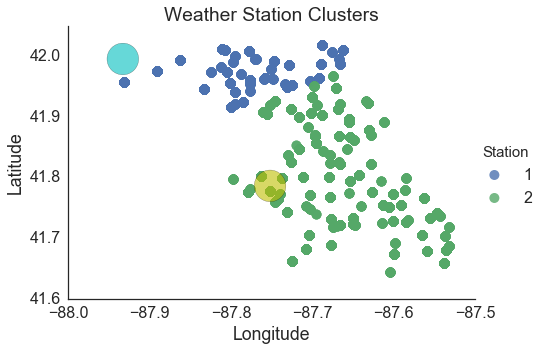

In [16]:
sns.set_context("notebook", font_scale=1.6)
sns.set_style("white")
sns.lmplot('Longitude', 'Latitude', data=df, fit_reg=False, hue="Station", aspect=1.4,
           scatter_kws={"marker": "D", "s": 100})
plt.title('Weather Station Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
area = 1000
colors = ['c','y']
plt.scatter([-87.933, -87.752], [41.995,41.786], 
            s=area, c = colors, marker='o', alpha=.6)
plt.figure(figsize=(12, 10))

In [31]:
df['Date'] = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

## Approach 1: Select 10 Best Features and use Random Forest Classifier

In [35]:
# define X and y, dropping unnecessary columns
X = df.drop(['Trap', 'Year','WnvPresent', 'NumMosquitos', 'date_station_id'], axis=1)
y = df['WnvPresent']

In [33]:
# select the 10 best features
kbest = SelectKBest(k=10)
X_kbest = kbest.fit_transform(X,y)

# get list of best feature names, and put into a dataframe for reference
best_features = [x for (x,y) in zip(X.columns, kbest.get_support().tolist()) if y==1]
X_kbest = pd.DataFrame(X_kbest, columns = best_features)

In [36]:
# GridSearch optimal Logistic Regression parameters
param_grid = {
    'C': [0.01,0.1,1,10],
    'penalty': ['l1', 'l2']
}
lg = LogisticRegression(n_jobs=-1)
gslg = GridSearchCV(lg, param_grid, n_jobs=-1)
gslg.fit(X_kbest, y)
gslg.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Model GS Logistic Regression classification metrics with default pred threshold:
Confusion Matrix 
[[8018    0]
 [ 457    0]]
Classification Report 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      8018
          1       0.00      0.00      0.00       457

avg / total       0.90      0.95      0.92      8475

Model GS Logistic Regression using prediction threshold 0.200000:
Confusion Matrix 
[[8018    0]
 [ 457    0]]
Classification Report 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      8018
          1       0.00      0.00      0.00       457

avg / total       0.90      0.95      0.92      8475

Model GS Logistic Regression ROC curve and AUC


array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

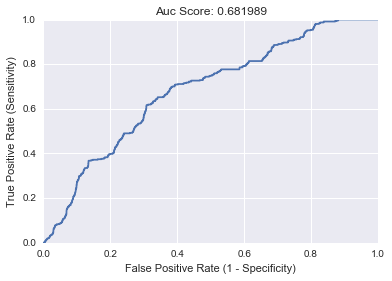

In [37]:
modelEval('GS Logistic Regression', gslg.best_estimator_, X_kbest, y, 0.2)

In [38]:
# GridSearch optimal Random Forest parameters
param_grid = {
    'min_samples_split': [2,10,20],
    'max_depth': [5,10,None],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [5,10,20]
}
rf = RandomForestClassifier(n_jobs=-1, random_state=rs)
gsrf = GridSearchCV(rf, param_grid, n_jobs=-1)
gsrf.fit(X_kbest, y)
gsrf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

Model GridSearched Random Forest classification metrics with default pred threshold:
Confusion Matrix 
[[8018    0]
 [ 457    0]]
Classification Report 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      8018
          1       0.00      0.00      0.00       457

avg / total       0.90      0.95      0.92      8475

Model GridSearched Random Forest using prediction threshold 0.100000:
Confusion Matrix 
[[6536 1482]
 [ 137  320]]
Classification Report 
             precision    recall  f1-score   support

          0       0.98      0.82      0.89      8018
          1       0.18      0.70      0.28       457

avg / total       0.94      0.81      0.86      8475

Model GridSearched Random Forest ROC curve and AUC


array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

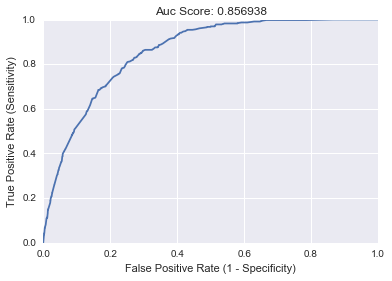

In [39]:
modelEval('GridSearched Random Forest', gsrf.best_estimator_, X_kbest, y, 0.1)

In [41]:
df['predictions'] = modelEval2('GridSearched Random Forest', gsrf.best_estimator_, X_kbest, y, 0.1)

In [ ]:
sns.set_context("notebook", font_scale=1.6)
sns.set_style("white")
sns.lmplot('Longitude', 'Latitude', data=df, fit_reg=False, hue="Station", aspect=1.4,
           scatter_kws={"marker": "D", "s": 100})
plt.title('Weather Station Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
area = 1000
colors = ['c','y']
plt.scatter([-87.933, -87.752], [41.995,41.786], 
            s=area, c = colors, marker='o', alpha=.6)
plt.figure(figsize=(12, 10))

In [43]:
zipped = zip(df.WnvPresent, df.predictions)
false_pos = []
false_neg = []
for a,b in zipped:
    if b > a:
        false_pos.append(1)
    else:
        false_pos.append(0)

for a,b in zipped:
    if b < a:
        false_neg.append(1)
    else:
        false_neg.append(0)

In [44]:
df['false_pos'] = false_pos
df['false_neg'] = false_neg

In [58]:
df_2013 = df['2013']

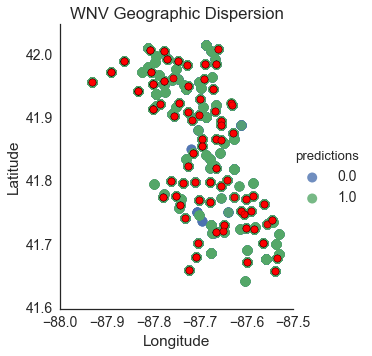

In [65]:
sns.set_context("notebook", font_scale=1.4)
sns.set_style("white")
sns.lmplot('Longitude', 'Latitude',
           data=df, 
           fit_reg=False, aspect = .9,
           hue="predictions", legend_out=True, scatter_kws={"marker": "D", "s": 100})
plt.title('WNV Geographic Dispersion')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
area = 50
# colors = ['c','y']
plt.scatter(df_2013.Longitude[df_2013.false_pos == 1], df_2013.Latitude[df_2013.false_pos == 1], 
            s=area, marker='o', c='r', alpha=.6)
plt.figure(figsize=(12, 10))

In [52]:
len(df.Longitude[df.false_pos == 1])

1482

In [53]:
len(df.index)

8475

## Approach 2: Perform Clustering, PCA and use Gridsearched Logistic Regression, Random Forest

#### Perform DBScan

In [31]:
from sklearn.cluster import DBSCAN
# Choose features to cluster
cols_for_cluster = ['NumMosquitos', 'Month', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 
                   'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 
                    'Tavg', 'PrecipTotal', 'Tmax', 'Tmin', 'DewPoint', 'prev_day_precip']
df_cluster = df[cols_for_cluster]
# Instantiate and fit cluster model
db = DBSCAN(eps=1, min_samples=40)
db.fit(df_cluster)
# Attach cluster labels to feature dataframe
df['cluster'] = db.labels_

Plot clusters

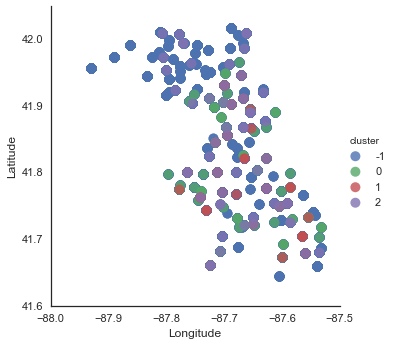

In [33]:
sns.lmplot('Longitude', 'Latitude', data=df, hue='cluster', fit_reg=False,
          scatter_kws={"marker": "D", "s": 100})

#### Conduct PCA

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
# Choose columns for PCA - mostly weather data
cols_for_pca = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 
                'PrecipTotal', 'ResultSpeed', 'AvgSpeed', 'ResultDir', 'StnPressure',
               'prev_day_precip']
X = df[cols_for_pca]
# Standardize
xStd = StandardScaler().fit_transform(X)
# Create covariance matrix, extract eigen pairings
covMat = np.cov(xStd.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)
totalEigen = sum(eigenValues)
# Compute cumulative explained variance
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cvarex = np.cumsum(varExpl)
print cvarex

[  48.15051028   65.45345693   75.73569346   83.16518344   89.26382919
   93.18317375   96.82856801   98.47721881   99.33231682   99.94604807
   99.99197627  100.          100.        ]


90% of the variance is explained by the first five components.

In [35]:
pcask = PCA(n_components=5)
Y = pcask.fit_transform(xStd)
Ydf = pd.DataFrame(Y)

### Logistic Regression

In [36]:
# Use PCA dataframe and add additional features
Ydf['Latitude'] = df.Latitude.values
Ydf['Longitude'] = df.Longitude.values
# Ydf['NumMosquitos'] = df.NumMosquitos.values
Ydf['erraticus'] = df['Species_CULEX ERRATICUS'].values
Ydf['pipiens'] = df['Species_CULEX PIPIENS'].values
Ydf['pip_rest'] = df['Species_CULEX PIPIENS/RESTUANS'].values
Ydf['restuans'] = df['Species_CULEX RESTUANS'].values
Ydf['salinarius'] = df['Species_CULEX SALINARIUS'].values
Ydf['tarsalis'] = df['Species_CULEX TARSALIS'].values
Ydf['territans'] = df['Species_CULEX TERRITANS'].values
Ydf['month'] = df.Month.values
Ydf['cluster'] = db.labels_
Ydf['pre_day_precip'] = df.prev_day_precip.values

In [37]:
X_pca = Ydf
y_pca = df.WnvPresent

In [38]:
# GridSearch optimal Logistic Regression parameters
param_grid = {
    'C': [0.01,0.1,1,10],
    'penalty': ['l1', 'l2']
}
gslg_pca = GridSearchCV(lg, param_grid, n_jobs=-1)
gslg_pca.fit(X_pca, y_pca)
gslg_pca.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Model GridSearch Logistic Regression classification metrics with default pred threshold:
Confusion Matrix 
[[8002   16]
 [ 434   23]]
Classification Report 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      8018
          1       0.59      0.05      0.09       457

avg / total       0.93      0.95      0.93      8475

Model GridSearch Logistic Regression using prediction threshold 0.200000:
Confusion Matrix 
[[7970   48]
 [ 412   45]]
Classification Report 
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      8018
          1       0.48      0.10      0.16       457

avg / total       0.93      0.95      0.93      8475

Model GridSearch Logistic Regression ROC curve and AUC


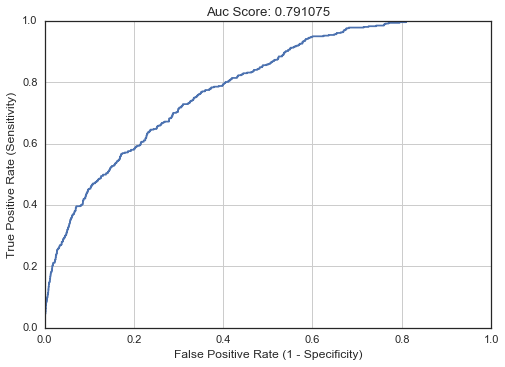

In [39]:
modelEval('GridSearch Logistic Regression',gslg_pca.best_estimator_, X_pca, y_pca, 0.2)

In [40]:
# GridSearch optimal Random Forest parameters
param_grid = {
    'min_samples_split': [2,10,20],
    'max_depth': [5,10,None],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [5,10,20]
}
gsrf_pca = GridSearchCV(rf, param_grid, n_jobs=-1)
gsrf_pca.fit(X_pca, y_pca)
gsrf_pca.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

Model GridSearched Random Forest classification metrics with default pred threshold:
Confusion Matrix 
[[8017    1]
 [ 446   11]]
Classification Report 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      8018
          1       0.92      0.02      0.05       457

avg / total       0.95      0.95      0.92      8475

Model GridSearched Random Forest using prediction threshold 0.200000:
Confusion Matrix 
[[7785  233]
 [ 263  194]]
Classification Report 
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      8018
          1       0.45      0.42      0.44       457

avg / total       0.94      0.94      0.94      8475

Model GridSearched Random Forest ROC curve and AUC


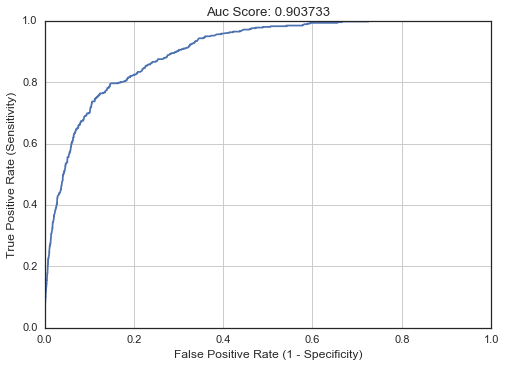

In [41]:
modelEval('GridSearched Random Forest', gsrf_pca.best_estimator_, X_pca, y_pca, 0.2)

In [4]:
df.head()

,Date,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Month,Year,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,...,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,date_station_id,prev_day_precip
0,2007-05-29,T096,41.731922,-87.677512,1,0,5,2007,0.0,1.0,...,421,1917,0.0,29.44,30.09,5.8,16,7.4,2007-05-29 00:00:002,0.0
1,2007-05-29,T159,41.732984,-87.649642,1,0,5,2007,0.0,0.0,...,421,1917,0.0,29.44,30.09,5.8,16,7.4,2007-05-29 00:00:002,0.0
2,2007-05-29,T153,41.907645,-87.760886,1,0,5,2007,0.0,0.0,...,421,1917,0.0,29.44,30.09,5.8,16,7.4,2007-05-29 00:00:002,0.0
3,2007-05-29,T129,41.891126,-87.611560,2,0,5,2007,0.0,0.0,...,421,1917,0.0,29.44,30.09,5.8,16,7.4,2007-05-29 00:00:002,0.0
4,2007-05-29,T096,41.731922,-87.677512,5,0,5,2007,0.0,0.0,...,421,1917,0.0,29.44,30.09,5.8,16,7.4,2007-05-29 00:00:002,0.0
